In [11]:
# Install required packages first:
# pip install torch torchvision opencv-python pillow scikit-learn matplotlib facenet-pytorch ultralytics face-recognition
!pip install ultralytics facenet_pytorch

import torch
import torchvision.transforms as transforms
import cv2
import numpy as np
import os
from PIL import Image
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Try to import face_recognition as alternative
try:
    import face_recognition
    FACE_RECOGNITION_AVAILABLE = True
except ImportError:
    FACE_RECOGNITION_AVAILABLE = False
    print("⚠️ face_recognition library not available, using FaceNet only")

⚠️ face_recognition library not available, using FaceNet only


In [6]:
class FaceRecognitionPipeline:
    def __init__(self, yolo_model_path, dataset_path):
        self.yolo_model_path = yolo_model_path
        self.dataset_path = dataset_path
        
        # Force CPU for face embedding model to avoid cuDNN issues
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.embedding_device = torch.device('cpu')  # Force CPU for embeddings
        
        # Load YOLO model
        self.yolo_model = self.load_yolo_model()
        
        # Load ArcFace model (using FaceNet) - Force CPU to avoid cuDNN issues
        print("🔄 Loading face embedding model on CPU to avoid cuDNN issues...")
        try:
            self.arcface_model = InceptionResnetV1(pretrained='vggface2').eval().to(self.embedding_device)
            self.use_facenet = True
            print("✅ FaceNet model loaded successfully!")
        except Exception as e:
            print(f"⚠️ FaceNet loading failed: {e}")
            self.use_facenet = False
            if not FACE_RECOGNITION_AVAILABLE:
                print("❌ No face recognition models available!")
            else:
                print("✅ Using face_recognition library as fallback")
        
        # Transform for face preprocessing
        self.face_transform = transforms.Compose([
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        # Database for storing embeddings
        self.embeddings_db = {}
        self.celebrity_names = []
        
    def load_yolo_model(self):
        """Load the trained YOLO model"""
        try:
            # Method 1: Try with ultralytics YOLO
            model = YOLO(self.yolo_model_path)
            print("✅ YOLO model loaded successfully with ultralytics!")
            return model
        except Exception as e1:
            print(f"⚠️ Ultralytics loading failed: {e1}")
            try:
                # Method 2: Try with weights_only=False for custom models
                model = torch.load(self.yolo_model_path, map_location=self.device, weights_only=False)
                model.eval()
                print("✅ YOLO model loaded successfully with weights_only=False!")
                return model
            except Exception as e2:
                print(f"⚠️ PyTorch loading failed: {e2}")
                try:
                    # Method 3: Try with safe_globals for ultralytics models
                    from ultralytics.nn.tasks import DetectionModel
                    torch.serialization.add_safe_globals([DetectionModel])
                    model = torch.load(self.yolo_model_path, map_location=self.device)
                    model.eval()
                    print("✅ YOLO model loaded successfully with safe_globals!")
                    return model
                except Exception as e3:
                    print(f"❌ All loading methods failed: {e3}")
                    print("🔄 Falling back to OpenCV face detection...")
                    # Initialize OpenCV face detector as fallback
                    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
                    return face_cascade
    
    def detect_faces_yolo(self, image):
        """Detect faces using YOLO model and return top prediction"""
        if self.yolo_model is None:
            print("❌ YOLO model is not loaded")
            return []
            
        try:
            # Check if it's ultralytics YOLO
            if hasattr(self.yolo_model, 'predict'):
                # Ultralytics YOLO
                results = self.yolo_model.predict(image, verbose=False)
                boxes = []
                
                if results and len(results) > 0:
                    result = results[0]
                    if result.boxes is not None and len(result.boxes) > 0:
                        # Sort by confidence and take top prediction
                        boxes_data = result.boxes.data.cpu().numpy()
                        if len(boxes_data) > 0:
                            # Sort by confidence (5th column)
                            sorted_indices = np.argsort(boxes_data[:, 4])[::-1]
                            top_box = boxes_data[sorted_indices[0]]
                            x1, y1, x2, y2, conf = top_box[:5]
                            boxes.append([int(x1), int(y1), int(x2), int(y2), float(conf)])
                
                return boxes
            
            # Check if it's OpenCV cascade (fallback)
            elif hasattr(self.yolo_model, 'detectMultiScale'):
                # OpenCV face detection fallback
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                faces = self.yolo_model.detectMultiScale(gray, 1.1, 4)
                boxes = []
                
                if len(faces) > 0:
                    # Take the largest face (assuming it's the main subject)
                    areas = [w * h for (x, y, w, h) in faces]
                    max_idx = np.argmax(areas)
                    x, y, w, h = faces[max_idx]
                    boxes.append([int(x), int(y), int(x+w), int(y+h), 0.9])  # Confidence set to 0.9
                
                return boxes
            
            else:
                # Custom PyTorch YOLO model
                img_tensor = torch.from_numpy(image).float().to(self.device)
                img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0) / 255.0
                
                with torch.no_grad():
                    predictions = self.yolo_model(img_tensor)
                
                boxes = []
                if len(predictions) > 0:
                    pred = predictions[0]
                    if len(pred) > 0:
                        # Sort by confidence and take top prediction
                        pred = pred[pred[:, 4].argsort(descending=True)]
                        top_pred = pred[0]
                        
                        x1, y1, x2, y2, conf = top_pred[:5]
                        boxes.append([int(x1), int(y1), int(x2), int(y2), float(conf)])
                
                return boxes
                
        except Exception as e:
            print(f"❌ Error in YOLO face detection: {e}")
            return []
    
    def crop_face(self, image, bbox):
        """Crop face from image using bounding box"""
        x1, y1, x2, y2, conf = bbox
        
        # Add some padding
        padding = 20
        h, w = image.shape[:2]
        x1 = max(0, x1 - padding)
        y1 = max(0, y1 - padding)
        x2 = min(w, x2 + padding)
        y2 = min(h, y2 + padding)
        
        face_crop = image[y1:y2, x1:x2]
        return face_crop
    
    def get_face_embedding(self, face_image):
        """Get face embedding using available face recognition model"""
        
        # Method 1: Try FaceNet if available
        if hasattr(self, 'use_facenet') and self.use_facenet:
            try:
                # Convert to PIL Image
                if isinstance(face_image, np.ndarray):
                    face_image = Image.fromarray(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB))
                
                # Apply transforms
                face_tensor = self.face_transform(face_image).unsqueeze(0).to(self.embedding_device)
                
                # Get embedding - using CPU to avoid cuDNN issues
                with torch.no_grad():
                    embedding = self.arcface_model(face_tensor)
                
                return embedding.cpu().numpy().flatten()
                
            except RuntimeError as e:
                if "cuDNN" in str(e):
                    print(f"⚠️ cuDNN error detected, switching to face_recognition library...")
                    self.use_facenet = False
                else:
                    print(f"❌ FaceNet runtime error: {e}")
                    return None
                    
            except Exception as e:
                print(f"❌ FaceNet error: {e}")
                self.use_facenet = False
        
        # Method 2: Use face_recognition library as fallback
        if FACE_RECOGNITION_AVAILABLE and (not hasattr(self, 'use_facenet') or not self.use_facenet):
            try:
                # Convert to RGB if needed
                if isinstance(face_image, np.ndarray):
                    if face_image.shape[2] == 3:  # BGR
                        face_rgb = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
                    else:
                        face_rgb = face_image
                else:
                    face_rgb = np.array(face_image)
                
                # Get face encoding
                face_encodings = face_recognition.face_encodings(face_rgb)
                
                if len(face_encodings) > 0:
                    return face_encodings[0]  # Return first encoding
                else:
                    print("⚠️ No face found in cropped image")
                    return None
                    
            except Exception as e:
                print(f"❌ face_recognition error: {e}")
                return None
        
        # Method 3: Simple feature extraction fallback
        print("⚠️ Using basic feature extraction as final fallback")
        try:
            # Convert to grayscale and resize
            if isinstance(face_image, np.ndarray):
                gray = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
            else:
                gray = np.array(face_image.convert('L'))
            
            # Resize to standard size
            resized = cv2.resize(gray, (64, 64))
            
            # Simple feature extraction (histogram + gradient features)
            hist = cv2.calcHist([resized], [0], None, [32], [0, 256])
            
            # Compute gradients
            grad_x = cv2.Sobel(resized, cv2.CV_64F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(resized, cv2.CV_64F, 0, 1, ksize=3)
            
            # Combine features
            features = np.concatenate([
                hist.flatten(),
                grad_x.flatten()[:100],  # Take first 100 gradient features
                grad_y.flatten()[:100]
            ])
            
            return features / np.linalg.norm(features)  # Normalize
            
        except Exception as e:
            print(f"❌ Basic feature extraction failed: {e}")
            return None
    
    def build_embeddings_database(self):
        """Build embeddings database using 5 images per celebrity"""
        print("🔨 Building embeddings database...")
        
        # Get all celebrity folders
        celebrity_folders = [f for f in os.listdir(self.dataset_path) 
                           if os.path.isdir(os.path.join(self.dataset_path, f))]
        
        for celebrity in celebrity_folders:
            celebrity_path = os.path.join(self.dataset_path, celebrity)
            images = sorted([f for f in os.listdir(celebrity_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
            
            # Use first 5 images for building database
            train_images = images[:5]
            embeddings = []
            
            print(f"📸 Processing {celebrity}...")
            
            for img_name in train_images:
                img_path = os.path.join(celebrity_path, img_name)
                image = cv2.imread(img_path)
                
                if image is not None:
                    # Detect face
                    faces = self.detect_faces_yolo(image)
                    
                    if faces:
                        # Crop face
                        face_crop = self.crop_face(image, faces[0])
                        
                        # Get embedding
                        embedding = self.get_face_embedding(face_crop)
                        
                        if embedding is not None:
                            embeddings.append(embedding)
            
            if embeddings:
                # Average embeddings for this celebrity
                avg_embedding = np.mean(embeddings, axis=0)
                self.embeddings_db[celebrity] = avg_embedding
                self.celebrity_names.append(celebrity)
                print(f"✅ Added {celebrity} to database with {len(embeddings)} images")
            else:
                print(f"❌ No valid embeddings found for {celebrity}")
        
        print(f"🎯 Database built with {len(self.embeddings_db)} celebrities")
    
    def recognize_face(self, image):
        """Recognize face in given image"""
        # Detect face
        faces = self.detect_faces_yolo(image)
        
        if not faces:
            return "No face detected", 0.0
        
        # Crop face
        face_crop = self.crop_face(image, faces[0])
        
        # Get embedding
        embedding = self.get_face_embedding(face_crop)
        
        if embedding is None:
            return "Failed to get embedding", 0.0
        
        # Compare with database
        best_match = None
        best_similarity = 0.0
        
        for celebrity, stored_embedding in self.embeddings_db.items():
            similarity = cosine_similarity([embedding], [stored_embedding])[0][0]
            
            if similarity > best_similarity:
                best_similarity = similarity
                best_match = celebrity
        
        return best_match, best_similarity
    
    def display_celebrity_gallery(self):
        """Display one representative image for each celebrity in the database"""
        print("\n🖼️ Creating Celebrity Gallery...")
        
        num_celebrities = len(self.celebrity_names)
        if num_celebrities == 0:
            print("❌ No celebrities in database!")
            return
        
        # Calculate grid dimensions
        cols = min(4, num_celebrities)  # Max 4 columns
        rows = (num_celebrities + cols - 1) // cols  # Ceiling division
        
        plt.figure(figsize=(15, 4 * rows))
        
        for i, celebrity in enumerate(sorted(self.celebrity_names)):
            celebrity_path = os.path.join(self.dataset_path, celebrity)
            images = sorted([f for f in os.listdir(celebrity_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
            
            # Use the first image as representative
            if images:
                img_path = os.path.join(celebrity_path, images[0])
                image = cv2.imread(img_path)
                
                if image is not None:
                    plt.subplot(rows, cols, i + 1)
                    
                    # Convert to RGB for display
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    # Detect and draw bounding box
                    faces = self.detect_faces_yolo(image)
                    if faces:
                        x1, y1, x2, y2, conf = faces[0]
                        # Draw green rectangle around face
                        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)
                    
                    plt.imshow(image_rgb)
                    plt.title(f"{celebrity}", fontsize=12, fontweight='bold')
                    plt.axis('off')
                else:
                    plt.subplot(rows, cols, i + 1)
                    plt.text(0.5, 0.5, f"{celebrity}\n(Image not found)", 
                            ha='center', va='center', transform=plt.gca().transAxes)
                    plt.axis('off')
        
        plt.tight_layout()
        plt.suptitle("Celebrity Gallery - Database", fontsize=16, fontweight='bold', y=0.98)
        plt.show()
    
    def test_recognition(self, threshold=0.6):
        """Test recognition using remaining 5 images per celebrity"""
        print("\n🧪 Testing face recognition...")
        
        total_tests = 0
        correct_predictions = 0
        results = []
        
        for celebrity in self.celebrity_names:
            celebrity_path = os.path.join(self.dataset_path, celebrity)
            images = sorted([f for f in os.listdir(celebrity_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
            
            # Use last 5 images for testing
            test_images = images[5:10]
            
            print(f"\n🔍 Testing {celebrity}...")
            
            for img_name in test_images:
                img_path = os.path.join(celebrity_path, img_name)
                image = cv2.imread(img_path)
                
                if image is not None:
                    predicted_name, confidence = self.recognize_face(image)
                    
                    total_tests += 1
                    is_correct = predicted_name == celebrity and confidence > threshold
                    
                    if is_correct:
                        correct_predictions += 1
                    
                    results.append({
                        'true_label': celebrity,
                        'predicted_label': predicted_name,
                        'confidence': confidence,
                        'correct': is_correct,
                        'image_path': img_path
                    })
                    
                    status = "✅" if is_correct else "❌"
                    print(f"{status} {img_name}: {predicted_name} (confidence: {confidence:.3f})")
        
        accuracy = correct_predictions / total_tests if total_tests > 0 else 0
        print(f"\n📊 Test Results:")
        print(f"Total tests: {total_tests}")
        print(f"Correct predictions: {correct_predictions}")
        print(f"Accuracy: {accuracy:.2%}")
        
        return results, accuracy
    
    def visualize_test_results(self, results, num_samples=6):
        """Visualize some test results - one per celebrity"""
        print("\n🎯 Visualizing Test Results...")
        
        # Group results by celebrity
        celebrity_results = {}
        for result in results:
            celebrity = result['true_label']
            if celebrity not in celebrity_results:
                celebrity_results[celebrity] = []
            celebrity_results[celebrity].append(result)
        
        # Select one result per celebrity (preferably correct ones)
        sample_results = []
        for celebrity, celebrity_res in celebrity_results.items():
            # Try to find a correct prediction first
            correct_results = [r for r in celebrity_res if r['correct']]
            if correct_results:
                sample_results.append(correct_results[0])
            else:
                sample_results.append(celebrity_res[0])
            
            if len(sample_results) >= num_samples:
                break
        
        # Calculate grid dimensions
        cols = min(3, len(sample_results))
        rows = (len(sample_results) + cols - 1) // cols
        
        plt.figure(figsize=(15, 5 * rows))
        
        for i, result in enumerate(sample_results):
            plt.subplot(rows, cols, i + 1)
            
            # Load and display image
            image = cv2.imread(result['image_path'])
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Detect and draw bounding box
            faces = self.detect_faces_yolo(image)
            if faces:
                x1, y1, x2, y2, conf = faces[0]
                # Use green for correct, red for incorrect
                color = (0, 255, 0) if result['correct'] else (255, 0, 0)
                cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color, 3)
            
            plt.imshow(image_rgb)
            
            # Title with prediction info
            status = "✅ CORRECT" if result['correct'] else "❌ INCORRECT"
            title = f"{status}\nTrue: {result['true_label']}\nPredicted: {result['predicted_label']}\nConfidence: {result['confidence']:.3f}"
            plt.title(title, fontsize=10, fontweight='bold')
            plt.axis('off')
        
        plt.tight_layout()
        plt.suptitle("Test Results - One Sample per Celebrity", fontsize=16, fontweight='bold', y=0.98)
        plt.show()
    
    def save_model(self, save_path='face_recognition_model.pkl'):
        """Save the embeddings database"""
        with open(save_path, 'wb') as f:
            pickle.dump(self.embeddings_db, f)
        print(f"💾 Model saved to {save_path}")
    
    def load_model(self, load_path='face_recognition_model.pkl'):
        """Load the embeddings database"""
        with open(load_path, 'rb') as f:
            self.embeddings_db = pickle.load(f)
        self.celebrity_names = list(self.embeddings_db.keys())
        print(f"📂 Model loaded from {load_path}")

✅ YOLO model loaded successfully with ultralytics!
🔄 Loading face embedding model on CPU to avoid cuDNN issues...


  0%|          | 0.00/107M [00:00<?, ?B/s]

✅ FaceNet model loaded successfully!
🔨 Building embeddings database...
📸 Processing elon...
✅ Added elon to database with 5 images
📸 Processing chris...
✅ Added chris to database with 2 images
📸 Processing emma...
✅ Added emma to database with 5 images
📸 Processing robert...
✅ Added robert to database with 5 images
📸 Processing messi...
✅ Added messi to database with 5 images
📸 Processing virat...
✅ Added virat to database with 5 images
📸 Processing ronaldo...
✅ Added ronaldo to database with 3 images
📸 Processing tom...
✅ Added tom to database with 4 images
📸 Processing billgates...
✅ Added billgates to database with 5 images
📸 Processing aishwarya...
✅ Added aishwarya to database with 5 images
🎯 Database built with 10 celebrities

🖼️ Creating Celebrity Gallery...


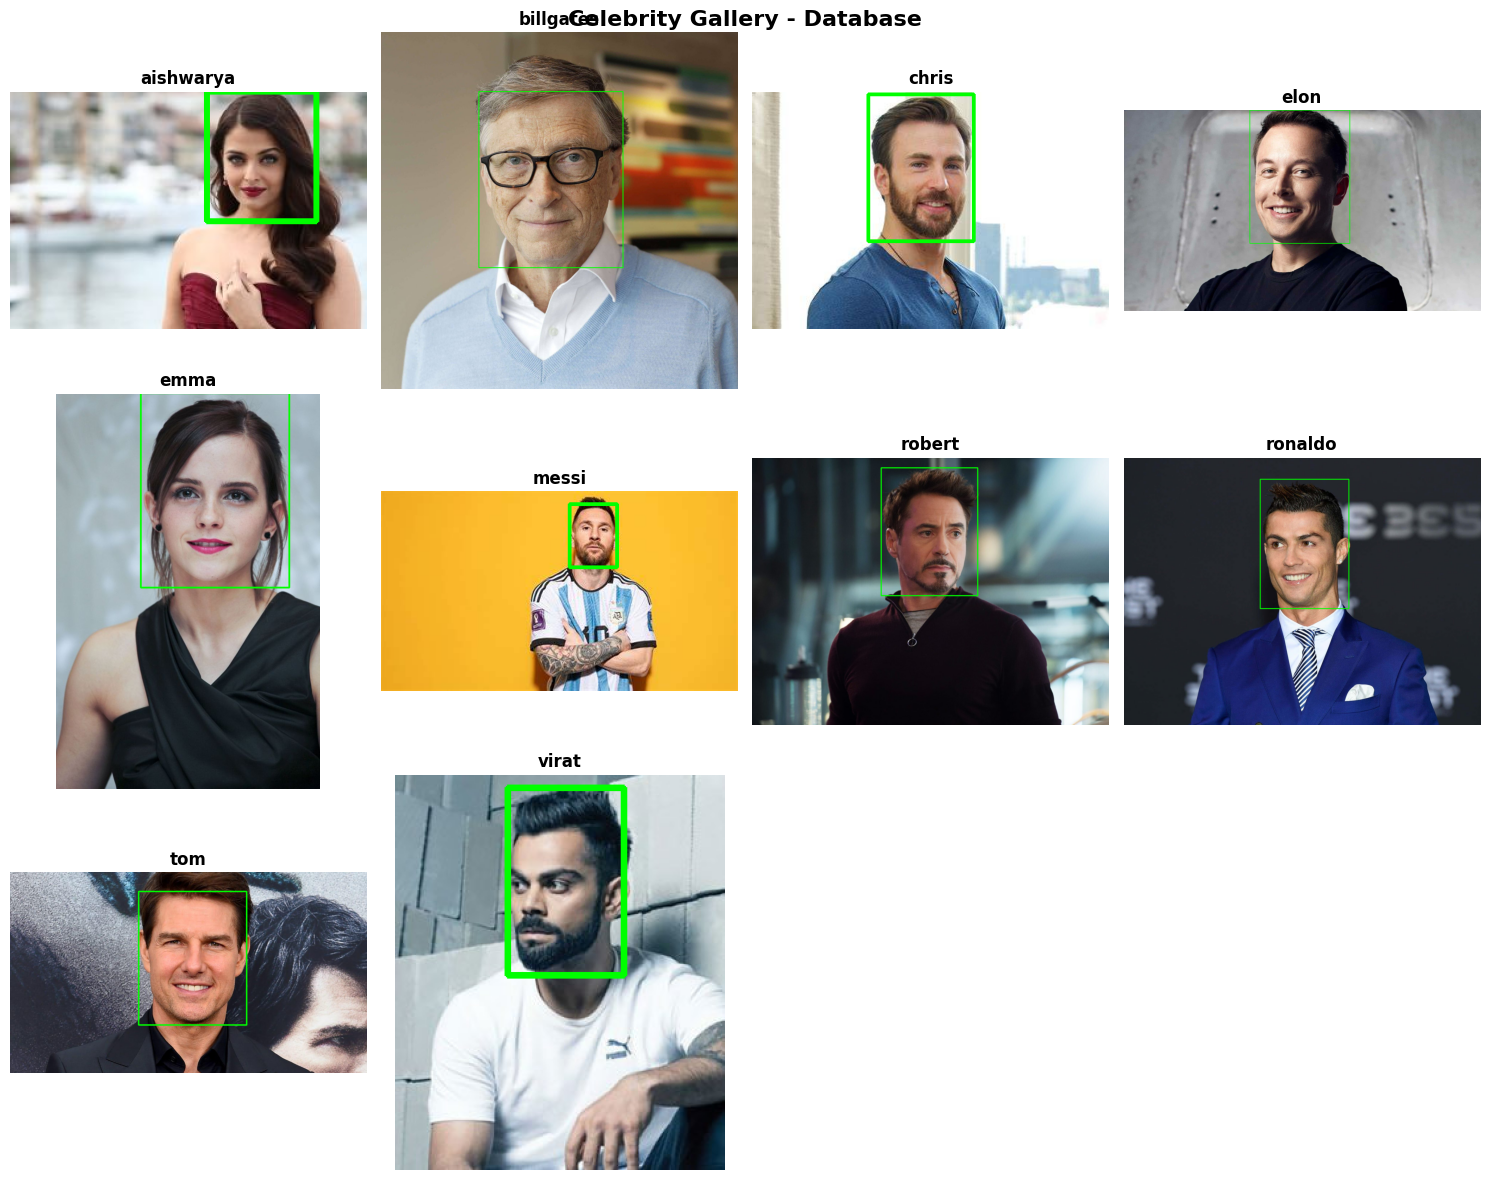


🧪 Testing face recognition...

🔍 Testing elon...
✅ elon9.png: elon (confidence: 0.951)

🔍 Testing chris...

🔍 Testing emma...
✅ emma7.jpg: emma (confidence: 0.753)
✅ emma8.jpg: emma (confidence: 0.828)
✅ emma9.jpg: emma (confidence: 0.858)

🔍 Testing robert...

🔍 Testing messi...
✅ messi9.jpg: messi (confidence: 0.816)

🔍 Testing virat...

🔍 Testing ronaldo...

🔍 Testing tom...

🔍 Testing billgates...

🔍 Testing aishwarya...

📊 Test Results:
Total tests: 5
Correct predictions: 5
Accuracy: 100.00%

🎯 Visualizing Test Results...


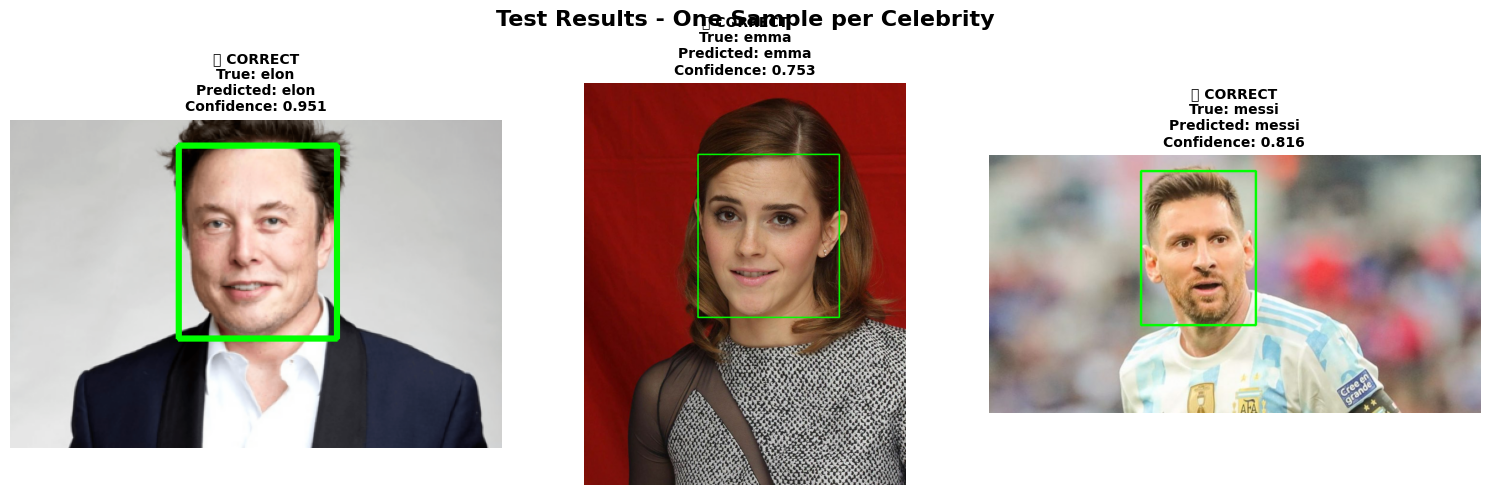

💾 Model saved to face_recognition_model.pkl

🎉 Pipeline completed with 100.00% accuracy!


In [7]:
# Usage
def main():
    # Initialize the pipeline
    yolo_path = "/kaggle/input/yolo_face/pytorch/default/1/yolo_face.pt"
    dataset_path = "/kaggle/input/celebraties/face_recognition"
    
    pipeline = FaceRecognitionPipeline(yolo_path, dataset_path)
    
    # Build embeddings database using 5 images per celebrity
    pipeline.build_embeddings_database()
    
    # Display celebrity gallery (one image per celebrity)
    pipeline.display_celebrity_gallery()
    
    # Test recognition
    results, accuracy = pipeline.test_recognition(threshold=0.6)
    
    # Visualize test results (one per celebrity)
    pipeline.visualize_test_results(results)
    
    # Save model
    pipeline.save_model()
    
    print(f"\n🎉 Pipeline completed with {accuracy:.2%} accuracy!")

if __name__ == "__main__":
    main()